# Residual and Sensitivity Analysis

## License 

Copyright 2017 J. Patrick Hall, jphall@gwu.edu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

#### Python imports

In [1]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.aggregator import H2OAggregatorEstimator

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in notebook
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999 # enable display of all columns in notebook
%matplotlib inline
import seaborn as sns

#### Start h2o

In [2]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpe8u_vlpt
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpe8u_vlpt/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmpe8u_vlpt/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,1 month and 12 days
H2O cluster name:,H2O_from_python_phall_2ix3y9
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **LIMIT_BAL**: Amount of given credit (NT dollar)
* **SEX**: 1 = male; 2 = female
* **EDUCATION**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **MARRIAGE**: 1 = married; 2 = single; 3 = others
* **AGE**: Age in years 
* **PAY_0, PAY_2 - PAY_6**: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **BILL_AMT1 - BILL_AMT6**: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005. 
* **PAY_AMT1 - PAY_AMT6**: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because H2O accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In [6]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics

In [7]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666688,,,,35.48549999999994,,,,,,,51223.33090000009,49179.07516666668,47013.15479999971,43262.9489666666,40311.40096666653,38871.76039999991,5663.580500000014,5921.16350000001,5225.681500000005,4826.076866666661,4799.387633333302,5215.502566666664,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720225,,,,9.21790406809016,,,,,,,73635.86057552959,71173.76878252836,69349.38742703681,64332.85613391641,60797.1557702648,59554.10753674574,16563.280354025763,23040.870402057226,17606.961469803115,15666.159744031993,15278.305679144793,17777.465775435332,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7808


#### Display variable importance

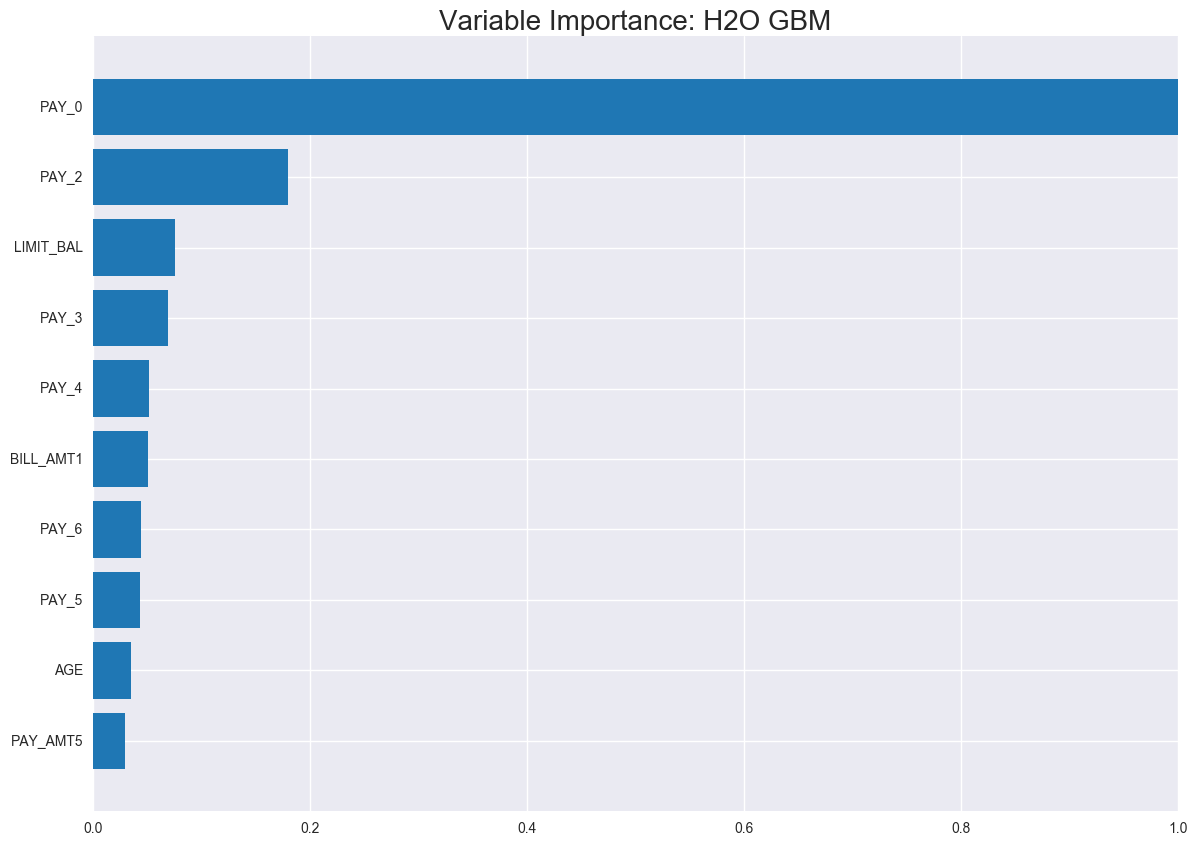

In [10]:
model.varimp_plot()

## 3. Conduct residual analysis to debug model

#### Bind model predictions onto test data 

In [11]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(test).drop(['predict', 'p0'])
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Calculate deviance residuals for binomial classification

In [12]:
# use Pandas for adding columns and plotting
test_yhat = test_yhat.as_data_frame()
test_yhat['s'] = 1
test_yhat.loc[test_yhat['DEFAULT_NEXT_MONTH'] == 0, 's'] = -1
test_yhat['r_DEFAULT_NEXT_MONTH'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

#### Plot residuals

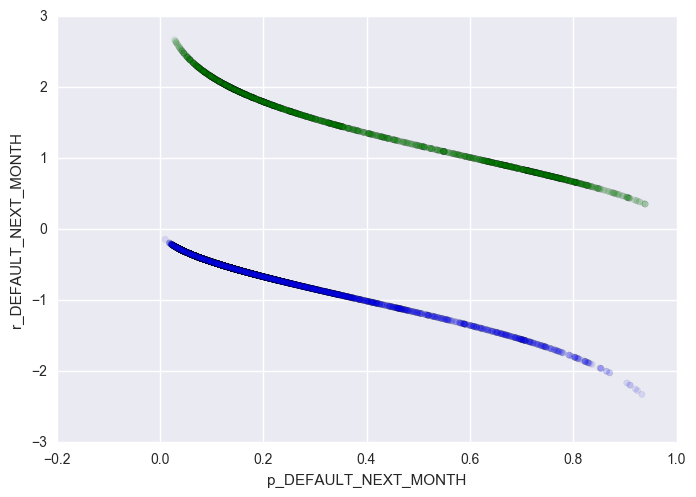

In [13]:
_ = test_yhat.plot(kind='scatter',
                   x=yhat,
                   y='r_DEFAULT_NEXT_MONTH',
                   color=test_yhat.DEFAULT_NEXT_MONTH.map({1:'g', 0:'b'}),
                   alpha=0.1)

#### Sort data by residuals and display data and residuals

In [14]:
test_yhat = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,18899,140000,female,other,single,28,use of revolving credit,use of revolving credit,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,108018,6500,6327,138485,140492,141006,1000,6327,135000,4700,5000,5000,1,0.028563,2.666700
1,25772,350000,female,graduate school,married,33,use of revolving credit,pay duly,pay duly,pay duly,pay duly,pay duly,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.030224,2.645421
2,6933,500000,male,graduate school,single,37,pay duly,pay duly,pay duly,pay duly,pay duly,pay duly,4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.030849,2.637673
3,13381,400000,female,university,single,35,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,109943,222085,223350,213831,210563,211925,120018,10071,8037,8018,8809,5022,1,0.031902,2.624911
4,2561,310000,female,graduate school,single,32,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.032029,2.623404
5,22751,350000,female,graduate school,married,32,pay duly,pay duly,no consumption,no consumption,no consumption,no consumption,30625,60003,7147,9950,22117,4874,60396,7147,9950,22117,4874,0,1,0.033741,2.603470
6,25692,330000,female,graduate school,single,42,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,565,20650,15360,0,12923,1816,20650,15360,0,12923,1816,17050,1,0.034929,2.590155
7,8339,480000,male,graduate school,married,58,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,24610,-310,148544,18791,5909,68988,4,149654,18885,5940,69337,200655,1,0.036294,2.575309
8,22712,320000,female,high school,married,35,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,157249,148123,142852,133583,129049,128325,6000,6048,6000,5000,5000,5000,1,0.037974,2.557673
9,28964,420000,female,university,married,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,pay duly,158471,44131,32423,18824,0,21082,1644,1436,1000,0,21082,228548,1,0.038392,2.553394


Model does worst on people who display consistently good payment behavior and then default and people who display dependably bad behavior and then fail to default. Worst outliers are those who seem very likely to default, but then don't.

#### Plot residuals by most important input variable 

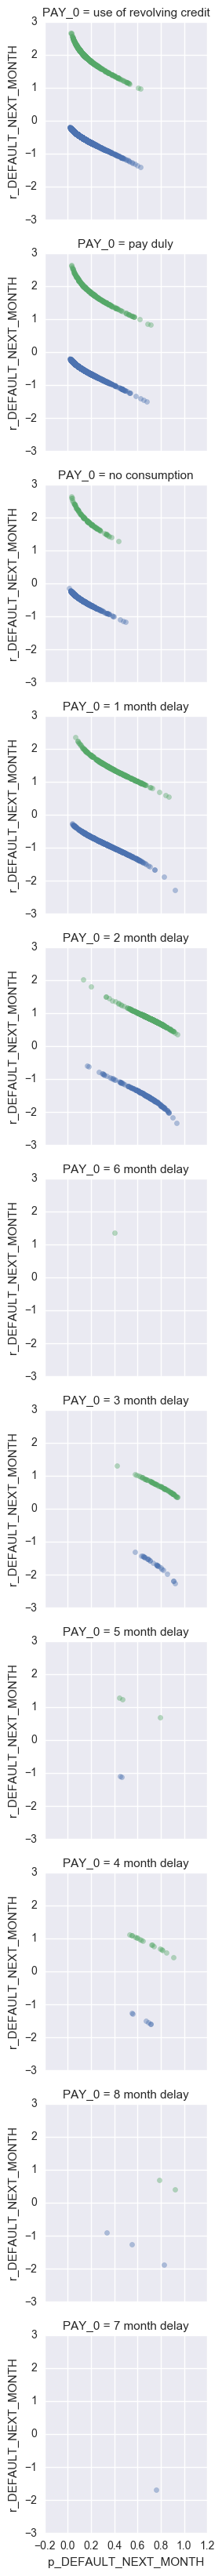

In [15]:
# use Seaborn FacetGrid for convenience
g = sns.FacetGrid(test_yhat, row='PAY_0', hue=y)
_ = g.map(plt.scatter, yhat, 'r_DEFAULT_NEXT_MONTH', alpha=0.4)

Residual story from most important variable matches story from overall residuals. Most obvious errors occur when someone makes their first payment and defaults later OR misses their first payment, but makes later payments.

## 4. Retrain GBM classifier based on results of residual analysis

#### Create a feature that contains information about behavior over time

In [16]:
data = data.as_data_frame()
data['bill_std'] = data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)
data.head(n=3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std
0,1,20000,female,university,married,24,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1761.633219
1,2,120000,female,university,single,26,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,637.967841
2,3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,6064.518593


#### Convert Pandas DataFrame back to H2OFrame for modeling

In [17]:
data = h2o.H2OFrame(data)                          # convert 
data[y] = data[y].asfactor()                       # ensure target is handled as a categorical variable
train, test = data.split_frame([0.7], seed=12345)  # split into training and validation

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Retrain GBM with new feature

In [18]:
# retrain GBM model
model.train(y=y,
            x=X + ['bill_std'], # add new feature
            training_frame=train, 
            validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7829


Slightly better accuracy, really need outside info to improve such as DTI.

## 5. Perform sensitivity analysis to test model performance on unseen data

#### Bind new model predictions onto test data 

In [19]:
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Helper function for finding quantile indices

In [20]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.as_data_frame()
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
pred_percentile_dict = get_percentile_dict(yhat, 'ID', test_yhat)
pred_percentile_dict

{0: 28716,
 10: 26033,
 20: 2460,
 30: 24255,
 40: 13100,
 50: 11365,
 60: 6414,
 70: 6351,
 80: 19705,
 90: 6066,
 99: 29116}

#### Display test data prediction range

In [21]:
print('Lowest prediction:', test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])][[y, yhat]])
print('Highest prediction:', test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])][[y, yhat]])

Lowest prediction: 

DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0,0.0102792



Highest prediction: 

DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
1,0.93937


Reasonable. If this was a regression problem, especially using neural networks, you would need to worry about unreasonable, high magnitude predictions.

#### Use trained model to test predictions for interesting situations: customer least likely to default

In [22]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,p_DEFAULT_NEXT_MONTH
28716,780000,female,university,single,41,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,101957,61715,38686,21482,72628,182792,62819,39558,22204,82097,184322,25695,0,57564.1,0.0102792


#### Test effect of changing sex

`SEX` is a variable that we should not see large changes in predicted values for. If we do, then this could indicate unwanted sociological bias.

In [23]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat])
test_case['SEX'] = 'male'
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
28716,780000,male,university,single,41,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,101957,61715,38686,21482,72628,182792,62819,39558,22204,82097,184322,25695,0,57564.1,0,0.969168,0.0308319


#### Test effect of changing PAY_0

From residual analysis, we know that the value of `PAY_0` can have a strong effect on model predictions, especially if it is different from later `PAY_`\* variables. 

In [24]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[0])]
test_case = test_case.drop([yhat])
test_case['PAY_0'] = '2 month delay' 
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
28716,780000,female,university,single,41,2 month delay,no consumption,no consumption,no consumption,no consumption,no consumption,101957,61715,38686,21482,72628,182792,62819,39558,22204,82097,184322,25695,0,57564.1,0,0.791697,0.208303


#### Use trained model to test predictions for interesting situations: customer most likely to default

In [25]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,p_DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1,1327.55,0.93937


#### Test effect of changing sex

In [26]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat])
test_case['SEX'] = 'male'
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
29116,20000,male,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1,1327.55,1,0.101381,0.898619


#### Test effect of changing PAY_0

In [27]:
test_case = test_yhat[test_yhat['ID'] == int(pred_percentile_dict[99])]
test_case = test_case.drop([yhat])
test_case['PAY_0'] = 'pay duly' 
test_case = test_case.cbind(model.predict(test_case))
test_case

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,bill_std,predict,p0,p1
29116,20000,female,university,married,59,pay duly,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1,1327.55,1,0.20868,0.79132


Model seems reasonably stable.

#### Shutdown H2O

In [28]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_97ae closed.
